# CA1: Electricity and MBA - Gabriel Villasmil

Table of Contents

- Scenario 1: Electricity
    - Loading Data
    - Feature Engineering
        - Total Data
        - Individual Data
    - EDA
        - Total Data (Box-Jenkins approach)
        - Individual Data
    - Model Development
    - Evaluation and Conclusion

- Scenario 2: MBA
    - Loading Data
    - Feature Engineering
    - EDA
    - Model Development
    - Evaluation and Conclusion
- References


# Scenario 1: Electricity

You have been provided with a dataset of historic Irish electricity generation (electricity.csv). Use appropriate time series methods, including a Box-Jenkins approach, to gain insights on current and future Irish electricity generation trends.

In your report, ensure that you include details about model selection and appropriateness, model tuning, model evaluation, and interpretation of any results.


## Loading Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Data
electricity_file = "electricity.csv"
electricity_data = pd.read_csv(electricity_file)

electricity_data

,Year of Period,Month of Period,Unit,Coal,Combust. Renew.,Hydro,Natural Gas,Oil,Other,Peat & BM,Solar Farms,Wastes,Wind
0,2024,January,GWh,99,13,132,"1,323",28,1,39,17,56,"1,142"
1,2024,February,GWh,86,12,114,992,11,1,54,20,50,"1,197"
2,2024,March,GWh,87,14,117,"1,020",6,1,49,35,23,"1,331"
3,2024,April,GWh,83,12,89,"1,072",5,1,52,65,39,929
4,2024,May,GWh,25,12,35,"1,350",25,1,59,94,56,560
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2010,August,GWh,226,0,14,"1,413",16,20,89,0,0,207
176,2010,September,GWh,220,0,51,"1,376",7,22,164,0,0,289
177,2010,October,GWh,275,0,41,"1,319",11,22,225,0,0,322
178,2010,November,GWh,296,0,101,"1,419",21,22,221,0,0,341


## Feature Engineering

A section of two will be made.
1. Total Data: Total Data will be sum of all the features in this dataset in just one single column (Total Electricity Generated). Here I amn going to build the model upon.
2. Individual Data: This, as the name states, will show the value of each feature independently, with this I am going to have some EDA done to study each type of energy individually.

### Total Data

In [4]:
# Lets create one Date column using 'Year of Period' and 'Month of Period'
electricity_data['Date'] = pd.to_datetime(
    electricity_data['Year of Period'].astype(str) + '-' + electricity_data['Month of Period'].astype(str) + '-01'
)
electricity_data.set_index('Date', inplace=True)

# Columns to numeric
energy_columns = ['Coal', 'Combust. Renew.', 'Hydro', 'Natural Gas', 'Oil', 
                  'Other', 'Peat & BM', 'Solar Farms', 'Wastes', 'Wind']

for col in energy_columns:
    electricity_data[col] = pd.to_numeric(electricity_data[col], errors='coerce')

# Get rid off rows where all energy values are NaN
electricity_data.dropna(subset=energy_columns, how='all', inplace=True)

electricity_data.sort_index(inplace=True)


### Individual Data

In [5]:
# Lets take advantage of my Software Developer background to come up with some fancy stuff

# Function to fill NaN values with the mean of the row above and below based on its column
def fill_with_mean(column_data):

    # Create target variable
    # Avoidding SettingWithCopyWarnings text
    column_data = column_data.copy() 

    # Iterate data through columns
    for i in range(len(column_data)):
        if pd.isna(column_data[i]):
            above = column_data[i - 1] if i > 0 else np.nan
            below = column_data[i + 1] if i < len(column_data) - 1 else np.nan
            # Row must be valid (have values)
            valid_values = [val for val in [above, below] if not pd.isna(val)]
            # Once valid, apply the mean
            column_data[i] = np.mean(valid_values) if valid_values else np.nan
    return column_data

# Run def and save into new variable
full_electricity_data = electricity_data.apply(fill_with_mean)


## EDA

### EDA Total Data

Following the Box-Jenkins approach:
- Augmented Dickey-Fuller Test to check stationary
- Differencing if necessary
- ACF and PACF plotting to select ARIMA paramethers (EDA)
- Model fitting (Model Development)
- Diagnosis (Evaluation and Conclusion)


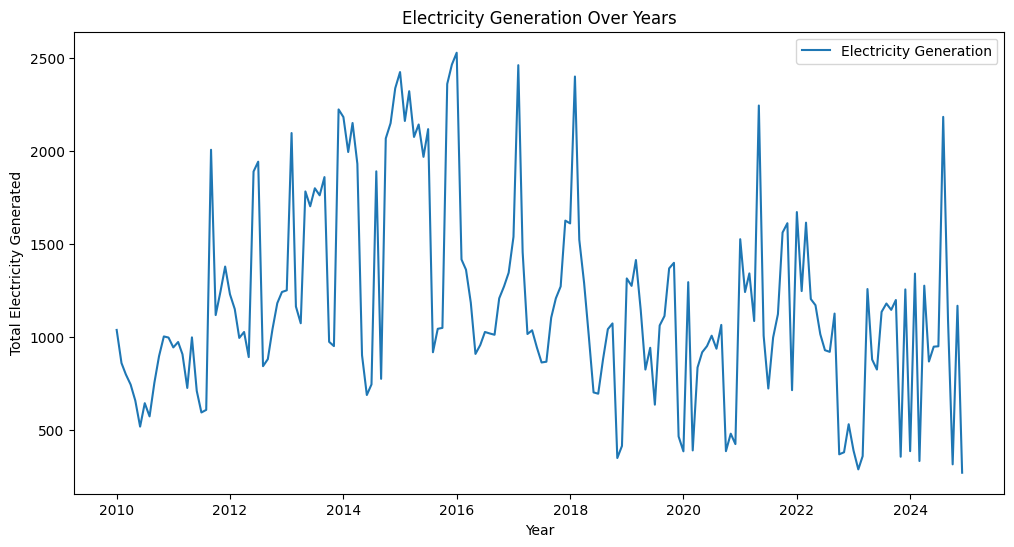

In [6]:
# Total electricity generation
electricity_data['Total Electricity Generated'] = electricity_data[energy_columns].sum(axis=1)

# Lets keep only total electricity generated column (Total data)
electricity_data = electricity_data[['Total Electricity Generated']]

# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(electricity_data, label='Electricity Generation')
plt.title('Electricity Generation Over Years')
plt.xlabel('Year')
plt.ylabel('Total Electricity Generated')
plt.legend()
plt.show()




In [7]:
# ADF Test to check stationary
adf_result = adfuller(electricity_data.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -5.297553635344078
p-value: 5.539906772702522e-06


- With a ADF much greater than -3.45
- p < 0.05

We reject the null hypothesis. the series is stationary.

Values shows that data seems to be **Stationary**

That means we can use the ARIMA model.


In [8]:
# Differencing, trust this, it will make the model perform better
electricity_data_diff = electricity_data.diff().dropna()

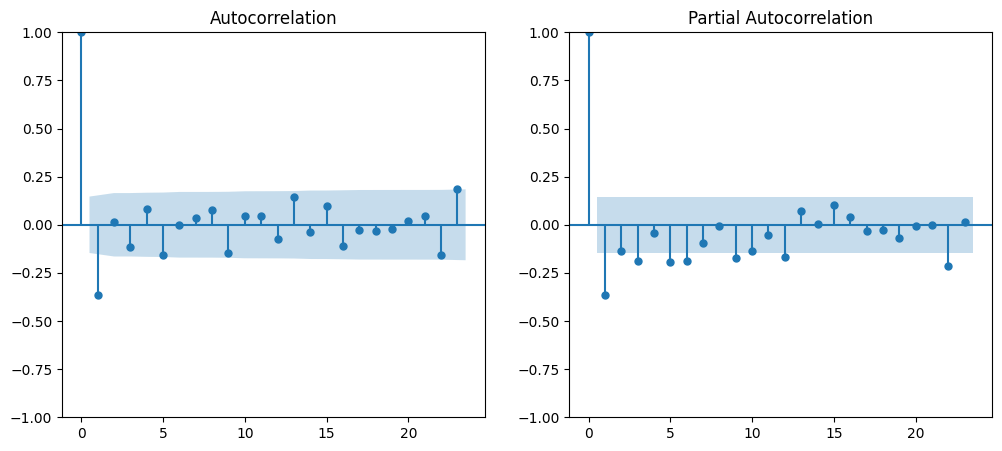

In [9]:
# ACF and PACF plots to determine ARIMA order
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(electricity_data_diff, ax=axes[0])
plot_pacf(electricity_data_diff, ax=axes[1])
plt.show()

There is a strong correlation at **lag 1**

### EDA Individual data

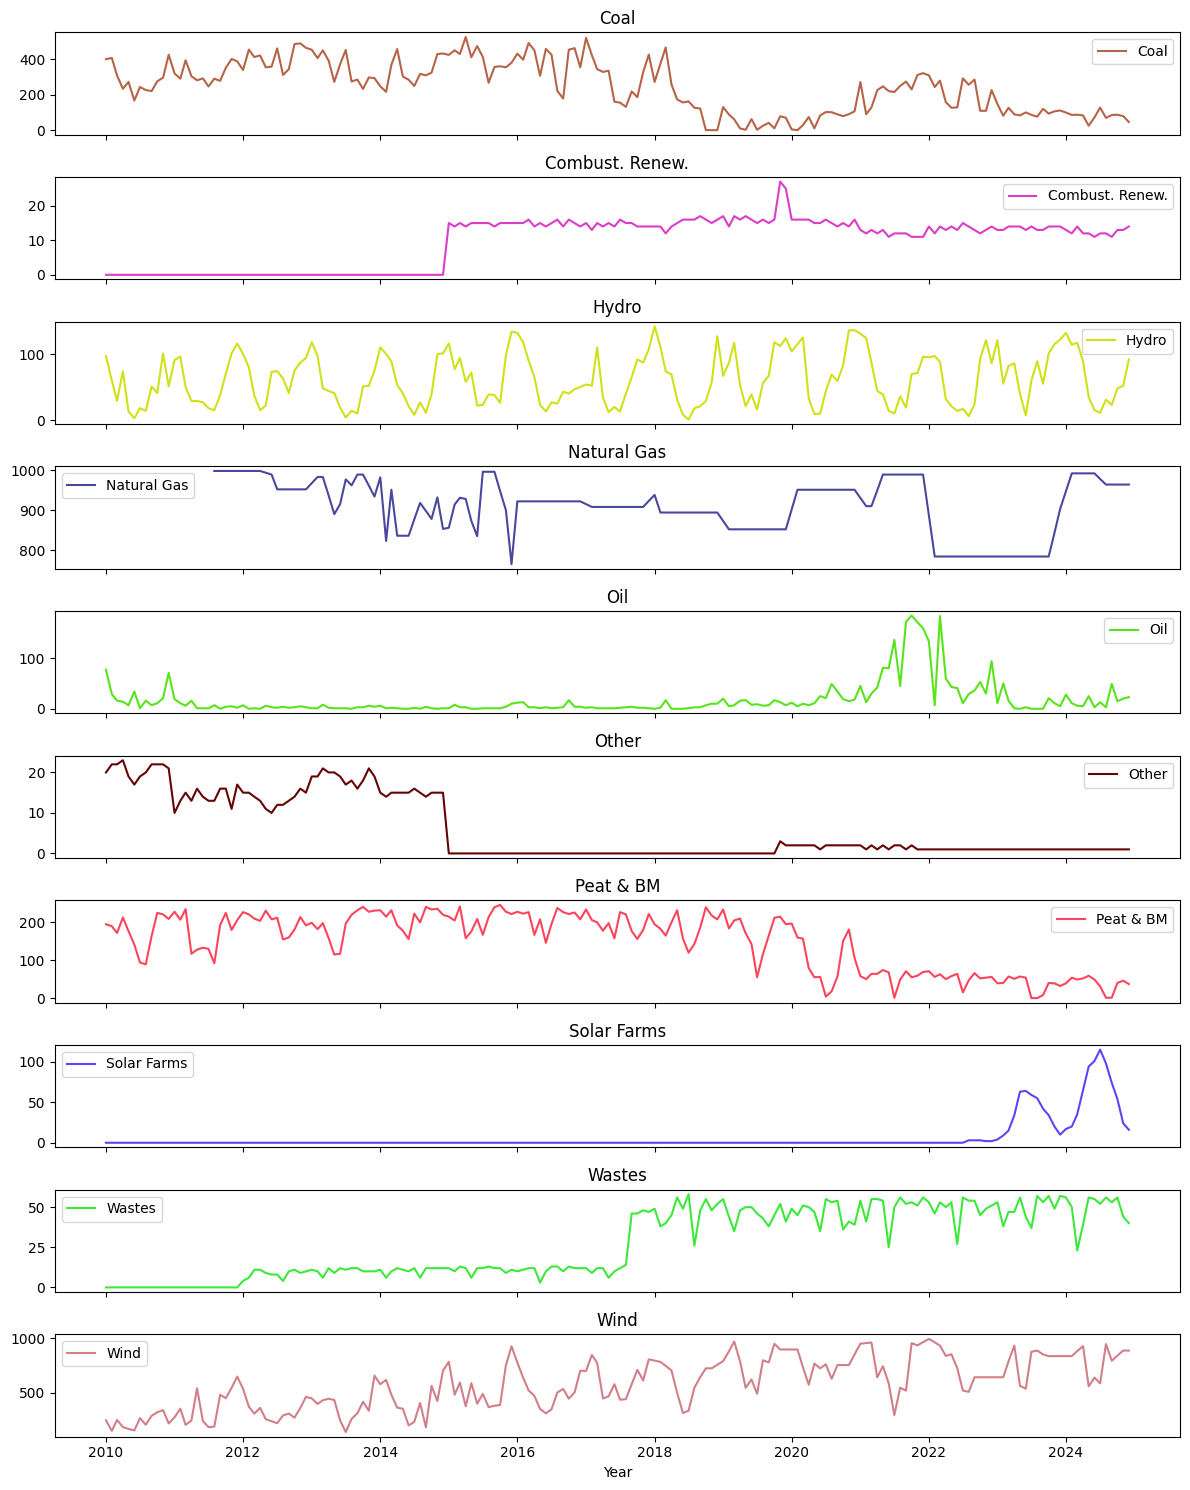

In [10]:
# Subplots to plot individually
fig, axes = plt.subplots(len(energy_columns), 1, figsize=(12, 15), sharex=True)

# Plotting  each energy separately
for i, col in enumerate(energy_columns):
    axes[i].plot(full_electricity_data.index, full_electricity_data[col], label=col, color=np.random.rand(3,))
    axes[i].set_title(col)
    axes[i].legend()

plt.xlabel('Year')
plt.tight_layout()
plt.show()

### EDA Conclusion

- First of all there are a variety of them that works in seasons: (Hydro, Coal, Natural Gas, Peat & BM, Wastes and Wind)
- Combust. Renew. seems to be more static while positive
- For this upcoming 12 months the ones that seems to bring the more electricity are:
    - Hydro
    - Combust. Renew.
    - Natural Gas
    - Wastes
    - Wind
- For this upcoming 12 months the ones that seems to bring the less electricity are:
    - Coal
    - Oil
    - Other
    - Peat & BM
    - Solar Farms

If we want to focus in one with a high steady demand I will have in mand **Combust. Renew.** energies sources.

If we want to focus on peak performance I will take a look into **Winds** Generators and **Natural Gas** 

Let's continue with the General Overview below


## Model Delopment

- p = 1 because its strong correlation
- d = 1 because the data have been forced stationary with .diff()
- q = 1 even though 2 show a good correlation, 1 still has a stronger one

In [11]:
# ARIMA model
model = ARIMA(electricity_data, order=(1, 1, 1)) 
model_fit = model.fit()

# Summary
model_fit.summary()


c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:     Total Electricity Generated   No. Observations:                  180
Model:                          ARIMA(1, 1, 1)   Log Likelihood               -1346.584
Date:                         Sun, 13 Apr 2025   AIC                           2699.168
Time:                                 10:01:11   BIC                           2708.730
Sample:                             01-01-2010   HQIC                          2703.046
                                  - 12-01-2024                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3506      0.084      4.170      0.000       0.186       0.515
ma.L1         -0.9051      0.042    -21.689      0.000      -0.987      -0.823
sigma2      1.993e+05   2.09e+04      9.523      0.000    1.58e+05     2.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 5.79
Prob(Q):                              0.70   Prob(JB):                         0.06
Heteroskedasticity (H):               1.14   Skew:                             0.42
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

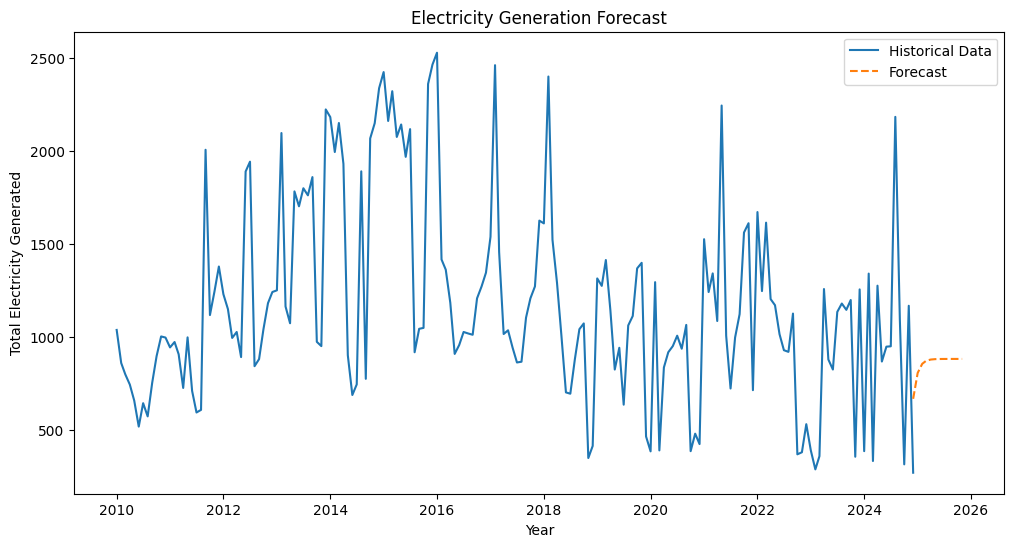

In [12]:
# Forecast values (next 12 months)
forecast_steps = 12 
forecast = model_fit.forecast(steps=forecast_steps)

# Plot 
plt.figure(figsize=(12, 6))
plt.plot(electricity_data, label='Historical Data')
plt.plot(pd.date_range(start=electricity_data.index[-1], periods=forecast_steps, freq='MS'), 
         forecast, label='Forecast', linestyle='dashed')
plt.title('Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Total Electricity Generated')
plt.legend()
plt.show()

## Evaluation and Conclusion

## 1. Evaluation 

In [13]:
# Predict values: Starting from the second as ARIMA can't predict the first
predicted_values = model_fit.fittedvalues[1:]

# Actual values: Must match predicted size to avoid errors
actual_values = electricity_data['Total Electricity Generated'][1:]


In [14]:
# MAE
mae = mean_absolute_error(actual_values, predicted_values)
print(f"MAE: {mae}")

# RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f"RMSE: {rmse}")

# MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
print(f"MAPE: {mape}%")

MAE: 343.73985981411687
RMSE: 446.43381178491074
MAPE: 38.90248207539487%


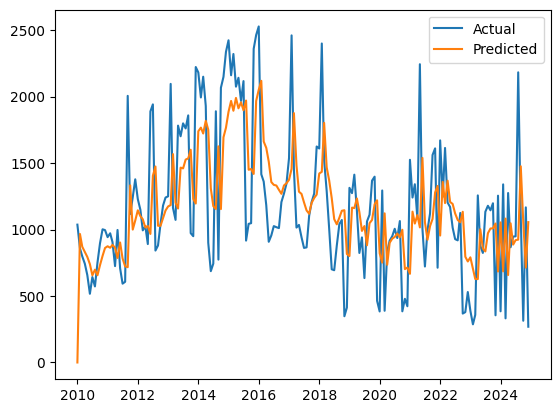

In [15]:
plt.plot(electricity_data, label='Actual')
plt.plot(model_fit.fittedvalues, label='Predicted')
plt.legend()
plt.show()


## 2. Conclusion

- Log Likelihood: our goal is to have this value closer to 0, (Same goes for AIC, BIC, and HQIC) at least it is not too high but they do not tell us too much, I need to compare them with the rest with the metrics.
- Residuals:
    - Ljung-Box (L1) (Q): 0.15
    - Prob(Q): 0.70
    - p > 0.05 = fail to reject the null, residuals looks like white noise.

    - JB = 5.79, p = 0.06
    - p > 0.05 = fail to reject the null, residuals are close to normal
- Forecast shows a period of **Growth** untill 2025 then a period of **Stagnation** untill 2026.
- ARIMA(1, 1, 1) would perform better in this case than ARIMA(1, 0, 1) even though the data was found stationary.
- MAPE: A good model fit would have a MAPE below 15%; in this case, I have 38.9%. It is like fitting a Random Forest and having a 0.62 in Accuracy. **It is not the greatest, but it is not too bad.**
- There are some pikes in Actual vs Predicted that are not being shown but seem to be very correlated with no residuals after all, signaling a good fit, at least in theory.

# Scenario 2: MBA

You have been provided with a dataset (mba.csv) of retail transactions. Use at least two Market Basket Analysis algorithms to find frequent itemsets and hence derive the associated association rules. 

In your report, ensure that you include details about parameter selection and tradeoffs, model evaluation, and interpretation of any results and rules.


## Loading Data

In [16]:
# Loading
data = pd.read_csv('mba.csv')

data.head()

,Product 1,Product 2,Product 3,Product 4,Product 5,Product 6,Product 7,Product 8,Product 9,Product 10,...,Product 23,Product 24,Product 25,Product 26,Product 27,Product 28,Product 29,Product 30,Product 31,Product 32
0,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, this dataset is not showing data as I want it to, I am looking through transactions instead of a table of products. What I am going to do is One-hot encode these transactions and get a new table with individual product names, and with that, see how many times these products appears in sales.



## Feature Engineering

I am going to get a new df with the values of each product individually instead of a list of purchases

In [17]:
# Flatten df
transactions = data.values.tolist()

# No Nan values
transactions = [[product for product in transaction if str(product) != 'nan'] for transaction in transactions]

# One-hot encoded df
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

In [18]:
df_encoded.columns

Index(['Instant food products', 'UHT-milk', 'abrasive cleaner',
       'artif. sweetener', 'baby cosmetics', 'baby food', 'bags',
       'baking powder', 'bathroom cleaner', 'beef',
       ...
       'turkey', 'vinegar', 'waffles', 'whipped/sour cream', 'whisky',
       'white bread', 'white wine', 'whole milk', 'yogurt', 'zwieback'],
      dtype='object', length=169)

In [19]:
df_encoded.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Mmmm... seems a little bit complicated, lest take advantage of Python to get an overview of at least the first 10 transactions.

I'm going to iterate each row of the dataset and find the values that show 'True'. Then I am going to concat them and print them with a nice phrase in the console showing the first 10 transactions

In [20]:
# List of items (Items + phrase)
transactions = []

# Logic
for index, row in df_encoded.iterrows():
    purchased_items = row[row == True].index.tolist()
    transactions.append(f"Row {index + 1}: The transaction contained {', '.join(purchased_items)}.")

# 10 first transactions
for transaction in transactions[:10]:
    print(transaction)

Row 1: The transaction contained citrus fruit, margarine, ready soups, semi-finished bread.
Row 2: The transaction contained coffee, tropical fruit, yogurt.
Row 3: The transaction contained whole milk.
Row 4: The transaction contained cream cheese, meat spreads, pip fruit, yogurt.
Row 5: The transaction contained condensed milk, long life bakery product, other vegetables, whole milk.
Row 6: The transaction contained abrasive cleaner, butter, rice, whole milk, yogurt.
Row 7: The transaction contained rolls/buns.
Row 8: The transaction contained UHT-milk, bottled beer, liquor (appetizer), other vegetables, rolls/buns.
Row 9: The transaction contained potted plants.
Row 10: The transaction contained cereals, whole milk.


## EDA

Let's do now some Data Visualizations before running into models, this would be beneficial at the moment we have to draw conclusions

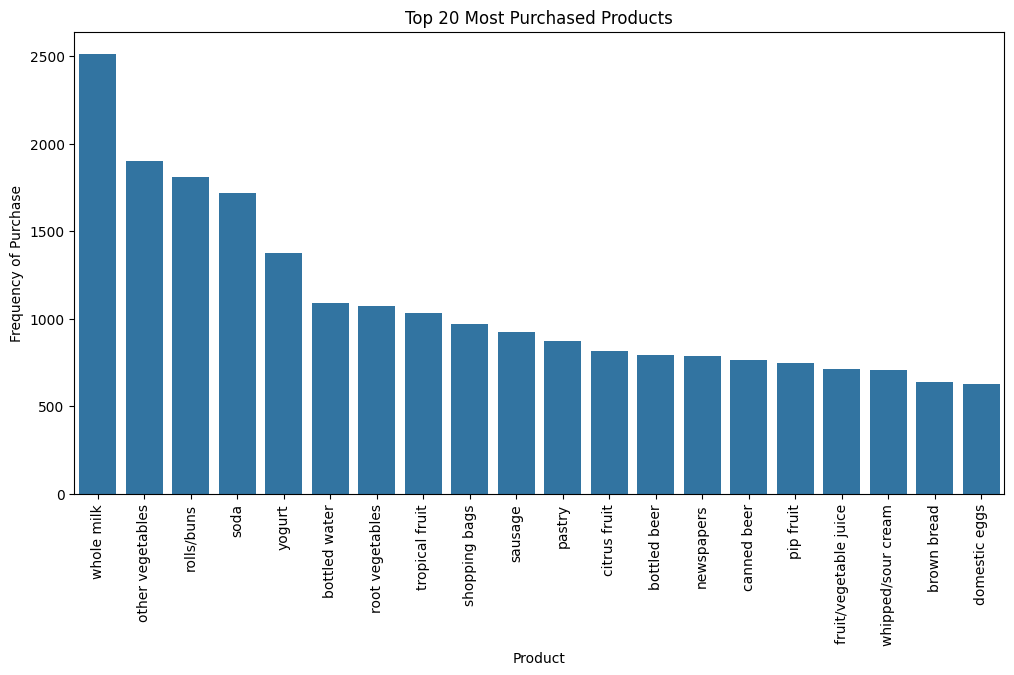

In [21]:
# Lets get number of times each product was bought
product_counts = df_encoded.sum(axis=0).sort_values(ascending=False)

# Plot: the 20 most bought 
plt.figure(figsize=(12,6))
sns.barplot(x=product_counts.index[:20], y=product_counts.values[:20]) 
plt.xticks(rotation=90)
plt.title("Top 20 Most Purchased Products")
plt.xlabel("Product")
plt.ylabel("Frequency of Purchase")
plt.show()



We can see that **Whole Milk** is our top-selling product, if we can find a relationship in MBA having this product, we most likely make several sales

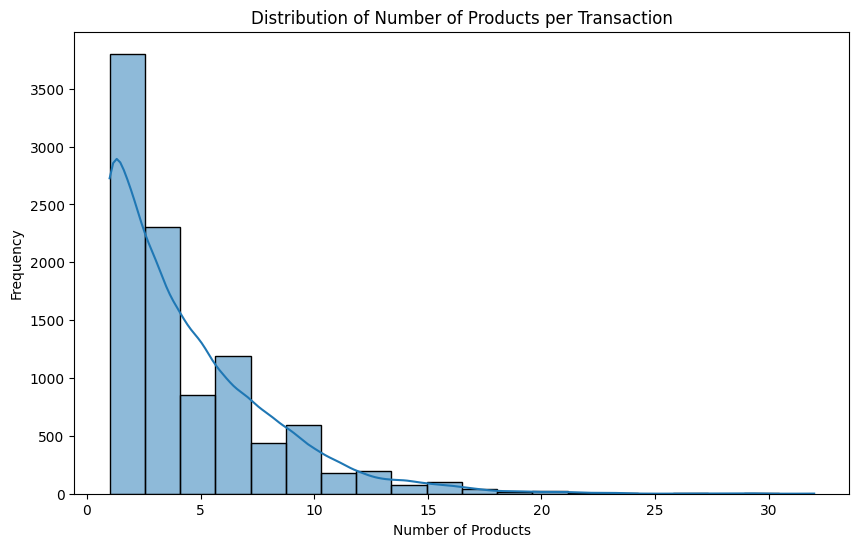

In [22]:
# Number of products per transaction
transactions_product_count = df_encoded.sum(axis=1)

# Plot
plt.figure(figsize=(10,6))
sns.histplot(transactions_product_count, bins=20, kde=True)
plt.title("Distribution of Number of Products per Transaction")
plt.xlabel("Number of Products")
plt.ylabel("Frequency")
plt.show()

Amazing results here: People in this store do not seem to buy a large number of products at once. Thanks to this I am going to focus on shorter and stronger basket product relationships rather than a wider one, I could increase the 0.05 min support, if necessary, to get only strong connections to **Whole Milk**.  If we do it right we can improve tremendously the revenue of this business.

## Model Development

In this case, I am going to use both the Apriori Algorithm and the FP-growth Algorithm. Both are great algorithms for frequent item correlations in datasets (MBA), and based on the internet, FP-growth tends to be better than Apriori in larger datasets. Before continuing with the models, Algorithms Parameter Selection and Tradeoffs are going to be discussed below: 

Being a classic problem, default parameters and normally agreed best practices are going to be set as the base for the solution

**Algorithms Parameter Selection**

- min_support: 0.05 (5%) are best practices. This tells the algorithm how many times an item must appear in order to be considered in a set. A high number means fewer items will be considered but will have a strong relationship, and a low number will have more but less valuable patterns.

- min_lift: This tells how strong the relationships found are. A higher lift means stronger patterns.

**Tradeoffs**

- min_support: With a more computation cost and a low min_support, it finds more patterns. But a high min_support, with a less computation cost, may find more trivial or irrelevant patterns.

- min_lift: a high lift can give you stronger patterns but some other possible interesting patterns will be omitted at that moment


In [23]:
# Apriori Algorithm

# Minimum support of 0.05 (5%)
frequent_itemsets_apriori = apriori(df_encoded, min_support=0.05, use_colnames=True)

# Rules
rules_apriori = association_rules(frequent_itemsets_apriori, metric="lift", min_threshold=1.2)

# Rules by confidence
rules_apriori_sorted = rules_apriori.sort_values(by='confidence', ascending=False)

# Show top 5 relationships
print("Top 5 Apriori Rules by Confidence:")
rules_apriori_sorted.head()


Top 5 Apriori Rules by Confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4,(yogurt),(whole milk),0.139502,0.255516,0.056024,0.401603,1.571735,1.0,0.020379,1.244132,0.422732,0.165267,0.196226,0.310432
0,(other vegetables),(whole milk),0.193493,0.255516,0.074835,0.386758,1.513634,1.0,0.025394,1.214013,0.420750,0.200000,0.176286,0.339817
2,(rolls/buns),(whole milk),0.183935,0.255516,0.056634,0.307905,1.205032,1.0,0.009636,1.075696,0.208496,0.147942,0.070369,0.264776
1,(whole milk),(other vegetables),0.255516,0.193493,0.074835,0.292877,1.513634,1.0,0.025394,1.140548,0.455803,0.200000,0.123228,0.339817
3,(whole milk),(rolls/buns),0.255516,0.183935,0.056634,0.221647,1.205032,1.0,0.009636,1.048452,0.228543,0.147942,0.046213,0.264776


In [24]:
# FP-growth Algorithm

# Minimum support of 0.05 (5%)
frequent_itemsets_fp = fpgrowth(df_encoded, min_support=0.05, use_colnames=True)

# Rules
rules_fp = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=1.2)

# Rules by confidence
rules_fp_sorted = rules_fp.sort_values(by='confidence', ascending=False)

# Show top 5 relationships
print("\nTop 5 FP-growth Rules by Confidence:")
rules_fp_sorted.head()



Top 5 FP-growth Rules by Confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(yogurt),(whole milk),0.139502,0.255516,0.056024,0.401603,1.571735,1.0,0.020379,1.244132,0.422732,0.165267,0.196226,0.310432
2,(other vegetables),(whole milk),0.193493,0.255516,0.074835,0.386758,1.513634,1.0,0.025394,1.214013,0.420750,0.200000,0.176286,0.339817
4,(rolls/buns),(whole milk),0.183935,0.255516,0.056634,0.307905,1.205032,1.0,0.009636,1.075696,0.208496,0.147942,0.070369,0.264776
3,(whole milk),(other vegetables),0.255516,0.193493,0.074835,0.292877,1.513634,1.0,0.025394,1.140548,0.455803,0.200000,0.123228,0.339817
5,(whole milk),(rolls/buns),0.255516,0.183935,0.056634,0.221647,1.205032,1.0,0.009636,1.048452,0.228543,0.147942,0.046213,0.264776


## Evaluation and Conclusion

**Evaluation**

- Confirming our EDA, Whole Milk is a top product with a variety of relatively strong relationships.

- **Whole Milk and Yogurt** is the strongest relationship we have with a confidence of 0.40 and the greatest lift of 1.57.

- Whole Milk is included in the top three strongest relationships by confidence.

- Dairy Food and Vegetables are our strongest connection.

**Conclusion**

- First of all, let's put Whole Milk and Yogurt as close as possible

- Marketing Campaigns, Promos, or Discounts need to be done on **Dairy Food**

- Dairy Food and Vegetable sections need to be closed and at the very end of the store, making the customer go all the way to the end, increasing the probability that they just remembered they need an extra item when they see it on the shelves.

- The bread section needs to be closed as well.

**Personal Comment**

Dairy food, Vegetables, and Bread are foods that go very fast. This store should be advertised as the freshest of the fresh first. Second when the product is about to go off, give a massive discount on the price, to serve both people with high level and low level of income.



# References
Ali, M. (2023). Association Rule Mining in Python Tutorial. [online] www.datacamp.com. Available at: https://www.datacamp.com/tutorial/association-rule-mining-python.

Brian (2018). How to elegantly one hot encode a series of lists in pandas. [online] Stack Overflow. Available at: https://stackoverflow.com/questions/52189126/how-to-elegantly-one-hot-encode-a-series-of-lists-in-pandas.

Çoğalan, A. (2023). FP-Growth Algorithm: How to Analyze User Behavior and Outrank Your Competitors. [online] Medium. Available at: https://medium.com/@anilcogalan/fp-growth-algorithm-how-to-analyze-user-behavior-and-outrank-your-competitors-c39af08879db.

Kadlaskar, A. (2021). Market basket Analysis | Guide on Market Basket Analysis. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-market-basket-analysis/.

KUMAR, S. (2022). Reading ARIMA Results. [online] Medium. Available at: https://medium.com/@sachinnayak18/reading-arima-results-35eb1df7a565.

LEONIE (2022). Time Series: Interpreting ACF and PACF. [online] kaggle.com. Available at: https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf.

rajaram, abhinaya (2021). Time Series in Python. [online] Data Science & Business. Available at: https://medium.com/data-science-business/time-series-arima-sarima-10f5b6a528d5.

Stack Overflow. (n.d.). python - Extracting just Month and Year separately from Pandas Datetime column. [online] Available at: https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column.

Zach (2021). Augmented Dickey-Fuller Test in Python (With Example). [online] Statology. Available at: https://www.statology.org/dickey-fuller-test-python/.